In [45]:
# IMPORT NECESSARY LIBRARIES
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder

In [4]:
# MOUNT GOOGLE DRIVE
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Cleaning

In [5]:
# BASE DATASET PATH
DATA_DIR = Path("/content/drive/MyDrive/Datasets/big-five-football-xg-data/")

# LOAD & COMBINE ALL CSV FILES
def load_raw_data(csv_dir):
    csv_dir = Path(csv_dir)
    dfs = [pd.read_csv(f) for f in csv_dir.glob("*.csv")]
    df = pd.concat(dfs, ignore_index=True)
    return df

# STANDARDIZE COLUMN NAMES
def standardize_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

# PARSE DATETIME SAFELY
def parse_datetime(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["time"] = df["time"].astype(str).str.zfill(5)
    df["datetime"] = pd.to_datetime(
        df["date"].astype(str) + " " + df["time"],
        errors="coerce"
    )
    return df

# CLEAN xG COLUMNS
def clean_xg(df):
    for col in ["xg_home", "xg_away"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        # xG sanity bounds
        df.loc[df[col] < 0, col] = np.nan
        df.loc[df[col] > 6, col] = np.nan
    return df

# PARSE SCORE INTO GOALS
def parse_score(df):
    df["score"] = (
        df["score"]
        .astype(str)
        .str.replace("–", "-", regex=False)
        .str.replace("—", "-", regex=False)
    )
    goals = df["score"].str.split("-", expand=True)
    df["home_goals"] = pd.to_numeric(goals[0], errors="coerce")
    df["away_goals"] = pd.to_numeric(goals[1], errors="coerce")
    return df

# CLEAN TEAM NAMES
def clean_team_names(df):
    for col in ["home", "away"]:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
        )
    return df

# REMOVE DUPLICATES
def remove_duplicates(df):
    df = df.drop_duplicates(
        subset=["datetime", "home", "away"]
    )
    return df

# DROP INDEX COLUMNS
def drop_index_columns(df):
    index_cols = [c for c in df.columns if c.startswith("unnamed")]
    return df.drop(columns=index_cols)

# LOGICAL VALIDATION
def validate_rows(df):
    conditions = (
        df["datetime"].notna() &
        df["home"].notna() &
        df["away"].notna() &
        df["xg_home"].notna() &
        df["xg_away"].notna() &
        df["home_goals"].notna() &
        df["away_goals"].notna()
    )
    df = df.loc[conditions].copy()
    return df

# FINAL CLEANING PIPELINE
def clean_match_data(csv_dir):
    df = load_raw_data(csv_dir)
    df = standardize_columns(df)
    df = parse_datetime(df)
    df = clean_xg(df)
    df = parse_score(df)
    df = clean_team_names(df)
    df = remove_duplicates(df)
    df = drop_index_columns(df)
    df = validate_rows(df)
    # Sort chronologically (CRITICAL)
    df = df.sort_values("datetime").reset_index(drop=True)
    return df

In [6]:
# SAVE CLEANED DATA
df_clean = clean_match_data(DATA_DIR)

OUTPUT_DIR = Path("/content/drive/MyDrive/Datasets/big-five-football-xg-data/processed/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

clean_path = OUTPUT_DIR / "matches_cleaned.csv"
df_clean.to_csv(clean_path, index=False)

print(f"Saved cleaned data to: {clean_path}")
print(f"Rows: {len(df_clean)}")

Saved cleaned data to: /content/drive/MyDrive/Datasets/big-five-football-xg-data/processed/matches_cleaned.csv
Rows: 9034


# 2. Feature Engineering

In [16]:
# LOAD CLEANED DATA
df_clean = pd.read_csv(clean_path)

EPSILON = 1e-6

# MATCH ID
def add_match_id(df):
    df["match_id"] = (
        df["home"] + "_vs_" + df["away"] + "_" +
        df["datetime"].dt.strftime("%Y%m%d_%H%M")
    )
    return df

# TARGET VARIABLE
def create_target(df):
    df = df.copy()
    df["result"] = np.select(
    [
        df["home_goals"] > df["away_goals"],
        df["home_goals"] == df["away_goals"],
        df["home_goals"] < df["away_goals"]
    ],
    ["home_win", "draw", "away_win"],
    default="unknown"
    )
    return df

# CORE xG FEATURES
def core_xg_features(df):
    df = df.copy()
    df["xg_diff"] = df["xg_home"] - df["xg_away"]
    df["total_xg"] = df["xg_home"] + df["xg_away"]
    df["home_xg_share"] = df["xg_home"] / (df["total_xg"] + EPSILON)
    df["xg_ratio"] = df["xg_home"] / (df["xg_away"] + EPSILON)
    return df

# FEATURE PIPELINE
def build_features(df):
    df = add_match_id(df)
    df = create_target(df)
    df = core_xg_features(df)
    df = df.dropna().reset_index(drop=True)
    return df

In [17]:
# SAVE FEATURES
INPUT_PATH = Path("/content/drive/MyDrive/Datasets/big-five-football-xg-data/processed/matches_cleaned.csv")
OUTPUT_PATH = Path("/content/drive/MyDrive/Datasets/big-five-football-xg-data/processed/matches_features.csv")

df_clean = pd.read_csv(INPUT_PATH, parse_dates=["datetime"])
df_features = build_features(df_clean)

df_features.to_csv(OUTPUT_PATH, index=False)

print(f"Saved feature dataset to: {OUTPUT_PATH}")
print(f"Rows: {len(df_features)}")

Saved feature dataset to: /content/drive/MyDrive/Datasets/big-five-football-xg-data/processed/matches_features.csv
Rows: 2288


# 3. Visualizations

### 3.1 Results Distribution

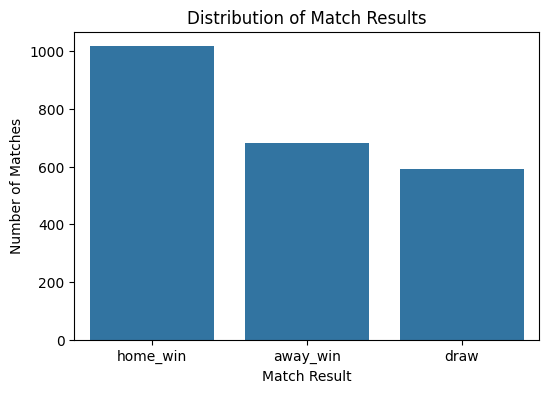

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(x='result', data=df_features)
plt.title("Distribution of Match Results")
plt.xlabel("Match Result")
plt.ylabel("Number of Matches")
plt.show()

### 3.2 xG Difference

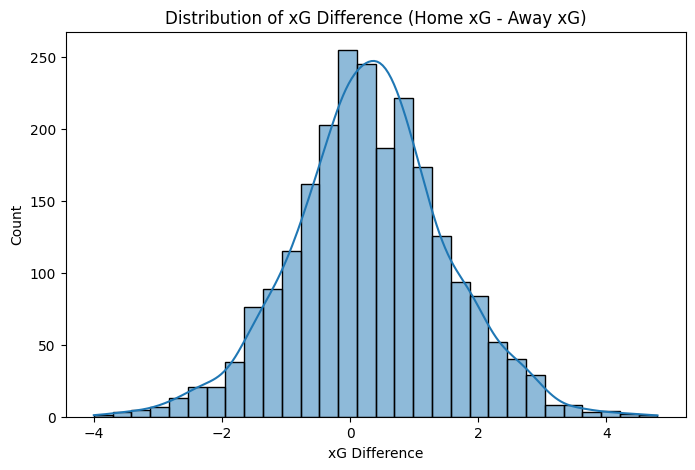

In [48]:
plt.figure(figsize=(8,5))
sns.histplot(df_features['xg_diff'], bins=30, kde=True)
plt.title("Distribution of xG Difference (Home xG - Away xG)")
plt.xlabel("xG Difference")
plt.ylabel("Count")
plt.show()

# 4. Modeling and Evaluation

### 4.1 Preparation

In [43]:
# List of non-numeric columns to drop from features
drop_cols = ['datetime', 'day', 'date', 'time', 'score', 'home', 'away', 'match_id', 'home_goals', 'away_goals', 'result', 'venue', 'referee', 'round']

# Features (X)
X = df_features.drop(columns=drop_cols)

# Target (y)
y = df_features['result']

# Assume df_features has a 'datetime' column
train_cutoff = '2021-08-01' # All matches before this date go into training

X_train = X[df_features['datetime'] < train_cutoff]
X_test = X[df_features['datetime'] >= train_cutoff]

y_train = y[df_features['datetime'] < train_cutoff]
y_test = y[df_features['datetime'] >= train_cutoff]

# Encode y for numeric labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Training/Testing Split
print("Training matches:", len(X_train))
print("Testing matches:", len(X_test))
print("Training date range:", df_features['datetime'].min(), "to", df_features['datetime'][df_features['datetime'] < train_cutoff].max())
print("Testing date range:", df_features['datetime'][df_features['datetime'] >= train_cutoff].min(), "to", df_features['datetime'].max())

Training matches: 1633
Testing matches: 655
Training date range: 2017-08-04 20:45:00 to 2021-05-22 15:30:00
Testing date range: 2021-08-06 21:00:00 to 2022-05-21 21:00:00


In [44]:
# SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 Logistic Regression

**Logistic Regression** is used for multi-class classification. In this project, the goal is to predict the outcome of a soccer match: home win, draw, or away win. It estimates the probability of each possible outcome using a logistic function that outputs values between 0 and 1 for each class. The class with the highest probability is chosen as the predicted match result.

For example, if the model predicts probabilities [0.6, 0.2, 0.2] for [home_win, draw, away_win], it classifies the match as a home win because that outcome has the highest probability.